**Imports necessary Python libraries for data manipulation, visualization, preprocessing, and anomaly detection.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from datetime import datetime



**Loads the CSV file into a pandas DataFrame and displays the first 5 rows**

In [2]:
df = pd.read_csv("/content/data (5) (1) (1) (1) (1)(internship-data-1).csv")
df.head(5)


,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
0,1/1/2017 0:00,867.63,910.42,-189.54,-186.04,852.13,-145.9
1,1/1/2017 0:05,879.23,918.14,-184.33,-182.1,862.53,-149.76
2,1/1/2017 0:10,875.67,924.18,-181.26,-166.47,866.06,-145.01
3,1/1/2017 0:15,875.28,923.15,-179.15,-174.83,865.85,-142.82
4,1/1/2017 0:20,891.66,934.26,-178.32,-173.72,876.06,-143.39


**Display the dataset shape and detailed info about columns, datatypes, and missing values.**

In [3]:
print("Size: ",df.shape)
df.info()

Size:  (357607, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357607 entries, 0 to 357606
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   time                      357607 non-null  object
 1   Cyclone_Inlet_Gas_Temp    357607 non-null  object
 2   Cyclone_Material_Temp     357607 non-null  object
 3   Cyclone_Outlet_Gas_draft  357607 non-null  object
 4   Cyclone_cone_draft        357607 non-null  object
 5   Cyclone_Gas_Outlet_Temp   357607 non-null  object
 6   Cyclone_Inlet_Draft       357607 non-null  object
dtypes: object(7)
memory usage: 19.1+ MB


The dataset contains 7 columns and 378,719 rows. All columns are of the object datatype. The `df.info()` output shows that there are null values in the dataset.

In [4]:
df.describe()

,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
count,357607,357607,357607,357607,357607,357607,357607
unique,357607,39597,39579,27453,26379,47977,23811
top,5/29/2020 16:15,Not Connect,0,Not Connect,Not Connect,28.88,Not Connect
freq,1,723,14221,723,723,2036,723


The `df.describe()` function provides descriptive statistics for the dataframe. For object data, it provides the count of non-null entries, the number of unique values, the most frequent value (top), and its frequency (freq). This output reveals that several columns contain the value "Not Connect", indicating data quality issues that need to be addressed. For example, in the `Cyclone_Inlet_Gas_Temp` column, "Not Connect" appears 723 times.

**Standardizes column names by stripping spaces and replacing them with underscores.**

In [5]:
df.columns = df.columns.str.strip().str.replace(" ", "_")


**Replaces all "Not Connect" strings with NaN to handle missing data properly.**

In [6]:
df.replace("Not Connect", np.nan, inplace=True)


**Converts all columns (except 'time') to numeric format, coercing errors to NaN**

In [7]:
cols_to_convert = df.columns.drop('time')
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')


**Converts the 'time' column to datetime format, handling invalid entries.**

In [8]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')


**Removes rows with missing timestamps and rows where all values are NaN.**

In [9]:
df.dropna(subset=['time'], inplace=True)
df.dropna(how='all', inplace=True)


**Prints the count of missing values in each column to assess the actual missing values and data cleanliness.**

In [10]:
missing_report = df.isna().sum()
print(missing_report)


time                           0
Cyclone_Inlet_Gas_Temp      1320
Cyclone_Material_Temp       1563
Cyclone_Outlet_Gas_draft    1321
Cyclone_cone_draft          1320
Cyclone_Gas_Outlet_Temp     1321
Cyclone_Inlet_Draft         1322
dtype: int64


**Saves the cleaned dataset to a new CSV file.**

In [11]:
df.to_csv("cleaned_dataset.csv", index=False)


**Specifies the list of numeric sensor columns to be used for modeling.**

In [12]:
sensor_cols = ['Cyclone_Inlet_Gas_Temp', 'Cyclone_Material_Temp', 'Cyclone_Outlet_Gas_draft',
               'Cyclone_cone_draft', 'Cyclone_Gas_Outlet_Temp', 'Cyclone_Inlet_Draft']

**StandardScaler to scale sensor values.**

**Scales sensor features to standard normal distribution using StandardScaler.**

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[sensor_cols])

**Isolation Forest model to detect anomalies in scaled sensor data.**

**Isolation Forest work better when data is normalized; this avoids bias from features with larger numeric ranges**

In [14]:
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['anomaly'] = model.fit_predict(X_scaled)

**Maps the model output: -1 to 1 (anomaly) and 1 to 0 (normal).**

In [15]:
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})


**Filters rows labeled as anomalies and prints the total count.**

In [16]:
anomalies = df[df['anomaly'] == 1]
print(f"Total Anomalies Detected: {len(anomalies)}")

Total Anomalies Detected: 3577


**Plots the time series of Cyclone_Material_Temp and highlights anomalies with red dots.**

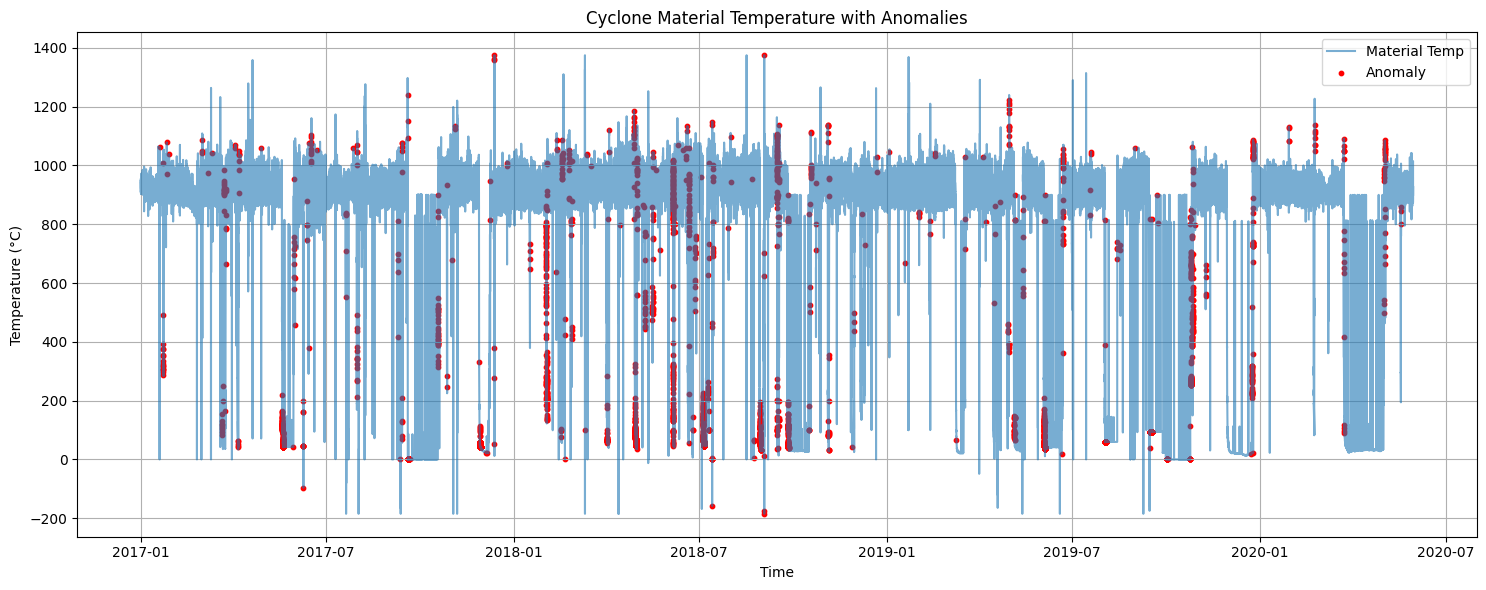

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(df['time'], df['Cyclone_Material_Temp'], label='Material Temp', alpha=0.6)
plt.scatter(anomalies['time'], anomalies['Cyclone_Material_Temp'], color='red', label='Anomaly', s=10)
plt.title('Cyclone Material Temperature with Anomalies')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Saves the full dataset with anomaly labels and a separate file for detected anomalies.**

In [18]:
df.to_csv("cleaned_with_anomalies.csv", index=False)
anomalies.to_csv("detected_anomalies.csv", index=False)

**Overall Summary**

- We performed end-to-end anomaly detection on cyclone preheater sensor data by first conducting data cleaning and EDA to handle non-numeric values and missing timestamps. We converted object data to numeric, handled "String" entries, and scaled the features. Using the Isolation Forest algorithm, we detected abnormal patterns in multivariate sensor readings. Finally, we visualized anomalies over time and saved both the cleaned dataset and anomaly records for further analysis.

- The raw dataset initially had all columns in string format with issues like "Not Connect" values, missing timestamps, and non-numeric sensor readings, making it unfit for analysis. After cleaning, we converted columns to proper formats, handled missing data, and standardized sensor values. Using Isolation Forest, we added an anomaly column that labeled ~1% of data points as abnormal based on unusual sensor behavior. The processed dataset is now clean, structured, and enriched with anomaly insights that were not visible earlier, enabling better analysis and time-based monitoring.
